# Creating Thumbnails of Images - Max  Dimension $\leq 256$

If an image is originally square with dimensions greater than 256x256, it will simply be resized to be 256x256; on the other hand, if an image is rectangular, say 460x780, it will first be resized so that the largest side length is 256, while maintaining the same aspect ratio. So, it will first be resized so that 780 becomes 256, and keeping the ratio, 460 will become $\approx 151$.

In [14]:
from PIL import Image
import glob, os

size = 256, 256

input_image_dir = 'images'
output_thumbnail_dir = 'thumbnails'

for infile in glob.glob(input_image_dir + '/*.jpg'):
    filename, ext = os.path.splitext(infile)
    basename = os.path.basename(filename)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(output_thumbnail_dir + '/' + basename + '_thumb.jpg', 'JPEG')

# Resizing and Cropping Images to Exactly 256x256

The next script _first_ resizes images such that the _shortest_ side becomes 256 pixels, and then crops the central regions of the images to make the final images exactly 256x256.

In [4]:
from __future__ import division

import math
import glob, os

from PIL import Image

side_length = 256
#side_length = 128

input_image_dir = 'images'
output_square_dir = 'square_images2'
#output_square_dir = 'square_images128'

for infile in glob.glob(input_image_dir + '/*.jpg'):
    filename, ext = os.path.splitext(infile)
    basename = os.path.basename(filename)
    
    im = Image.open(infile)
    
    [width, height] = im.size
    
    if width < height:
        ratio = height / width
        new_width = side_length
        new_height = int(math.ceil(ratio * new_width))
    else:
        ratio = width / height
        new_height = side_length
        new_width = int(math.ceil(ratio * new_height))
    
    resized_im = im.resize((new_width, new_height), Image.ANTIALIAS)
    
    if new_width != side_length:
        left_bound = int((new_width - side_length) / 2)
        upper_bound = 0
        right_bound = int((new_width + side_length) / 2)
        lower_bound = side_length
    else:
        left_bound = 0
        upper_bound = int((new_height - side_length) / 2)
        right_bound = side_length
        lower_bound = int((new_height + side_length) / 2)
        
    cropped_im = resized_im.crop((left_bound, upper_bound, right_bound, lower_bound))
    
    cropped_im.save(output_square_dir + '/' + basename + '_square.jpg', 'JPEG')

# Creating Tiny 16x16 (or 32x32) Images by Simple Resizing

This is the simplest possible method, which will squash aspect ratios.

In [107]:
from PIL import Image
import glob, os

size = 32, 32

input_image_dir = 'images'
output_tiny_dir = 'tiny_images_32'

for infile in glob.glob(input_image_dir + '/*.jpg'):
    filename, ext = os.path.splitext(infile)
    basename = os.path.basename(filename)
    im = Image.open(infile)
    resized_im = im.resize(size)
    resized_im.save(output_tiny_dir + '/' + basename + '_tiny.jpg', 'JPEG')

# Grouping Oxford 17 Flower Dataset Images into Folders for each Class

Here, we create the following directory structure:

For each class CLASS_K, we create a folder titled CLASS_K (using underscores when the class name contains spaces) and put all images of that class into that new folder.

We take advantage of the fact that in the 17-class dataset, each class consists of exactly 80 images, and all images of a particular class appear _consecutively_ in the original dataset. Thus, we can simply take chunks of 80-images each and create new folders for each of them. The only complication is that the dataset does not seem to come with an easy way to tell which class an image belongs to; I have manually determined the correct order of the classes for the following code.

In [8]:
import glob, os

classes = [
    'daffodil', 
    'snowdrop',
    'lily_valley',
    'bluebell',
    'crocus',
    'iris',
    'tigerlily',
    'tulip',
    'fritillary',
    'sunflower',
    'daisy',
    'colts_foot',
    'dandelion',
    'cowslip',
    'buttercup',
    'windflower',
    'pansy'
]

input_image_dir = 'square_images128'
files_per_class = 80

full_filenames = sorted(glob.glob(input_image_dir + '/*.jpg'))
filenames = [os.path.basename(full) for full in full_filenames]

for (class_index, class_name) in enumerate(classes):
    os.mkdir(input_image_dir + '/' + class_name)
    
    from_index = files_per_class * class_index
    to_index = files_per_class * class_index + files_per_class
    
    files_to_move = filenames[from_index:to_index]
    
    for filename in files_to_move:
        os.rename(input_image_dir + '/' + filename,
                  input_image_dir + '/' + class_name + '/' + filename)

['square_images128/image_0001_square.jpg', 'square_images128/image_0002_square.jpg', 'square_images128/image_0003_square.jpg', 'square_images128/image_0004_square.jpg', 'square_images128/image_0005_square.jpg', 'square_images128/image_0006_square.jpg', 'square_images128/image_0007_square.jpg', 'square_images128/image_0008_square.jpg', 'square_images128/image_0009_square.jpg', 'square_images128/image_0010_square.jpg', 'square_images128/image_0011_square.jpg', 'square_images128/image_0012_square.jpg', 'square_images128/image_0013_square.jpg', 'square_images128/image_0014_square.jpg', 'square_images128/image_0015_square.jpg', 'square_images128/image_0016_square.jpg', 'square_images128/image_0017_square.jpg', 'square_images128/image_0018_square.jpg', 'square_images128/image_0019_square.jpg', 'square_images128/image_0020_square.jpg', 'square_images128/image_0021_square.jpg', 'square_images128/image_0022_square.jpg', 'square_images128/image_0023_square.jpg', 'square_images128/image_0024_squa

# A Function to Load the Data into a Matrix - Come back to this

This function loads input flower data into a matrix X.

In [2]:
from __future__ import division

from PIL import Image

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

base_dir = 'tiny_images_32'
#base_dir = 'square_images_few'
image_width = 32
image_height = 32

classes = ['daffodil',  'snowdrop', 'lily_valley', 'bluebell', 'crocus', 'iris', 
           'tigerlily', 'tulip', 'fritillary', 'sunflower', 'daisy', 'colts_foot', 
           'dandelion', 'cowslip', 'buttercup', 'windflower', 'pansy']

class_dict = { class_name: index for (index, class_name) in enumerate(classes)}


folders = os.listdir(base_dir)
folders = [folder for folder in folders if folder != '.DS_Store']

xs = []
ys = []

for folder_name in folders:
    # We look up the class number based on the name of the folder the image is in.
    # This maps a folder name like 'daffodil' to a class number like 0.
    class_index = class_dict[folder_name]
    
    file_names = os.listdir(base_dir + '/' + folder_name)
    file_names = [name for name in file_names if name != '.DS_Store']
    
    X = np.empty([len(file_names), image_width, image_height, 3])
    y = []
    
    for (index, file_name) in enumerate(file_names):
        file_path = base_dir + '/' + folder_name + '/' + file_name
        I = np.array(Image.open(file_path))
        X[index] = I
        y.append(class_index)
    
    X_combined = X
    y_array = np.array(y)
    xs.append(X_combined)
    ys.append(y_array)
    
    
X_all = np.concatenate(xs)
y_all = np.concatenate(ys)

print(X_all.shape)
print(y_all.shape)

# Flatten the data so that each row in X_all_rows represents an image
X_all_rows = X_all.reshape(X_all.shape[0], image_width * image_height * 3)
#X_all_rows = np.reshape(X_all_rows, (X_all_rows.shape[0], -1))

print(X_all_rows.shape)

# Randomly shuffle the input images and labels (IN THE SAME RANDOM ORDER SO THEY ARE STILL CORRELATED)
rng_state = np.random.get_state()
np.random.shuffle(X_all_rows)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

(1360, 32, 32, 3)
(1360,)
(1360, 3072)


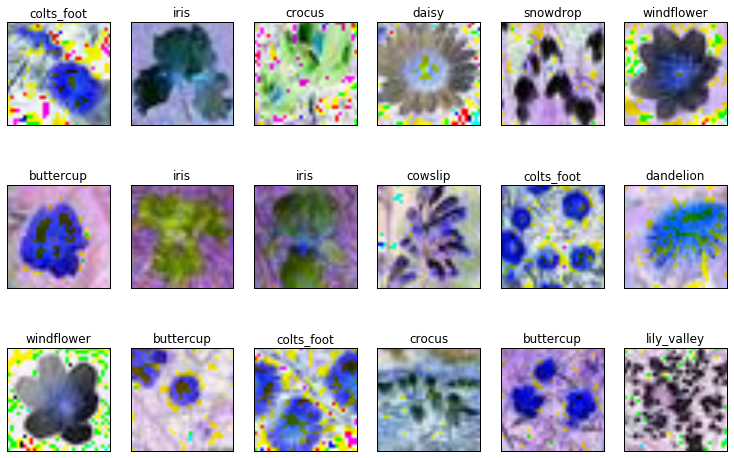

In [4]:
def plot_gallery(images, labels, w, h, n_row=3, n_col=6):
    """Plot a gallery of flowers"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        #plt.imshow(images[i].reshape((w,h,3)).astype('uint8'))
        plt.imshow(images[i].reshape((w,h,3)))
        plt.title(classes[labels[i]], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_all_rows, y_all, image_width, image_height)

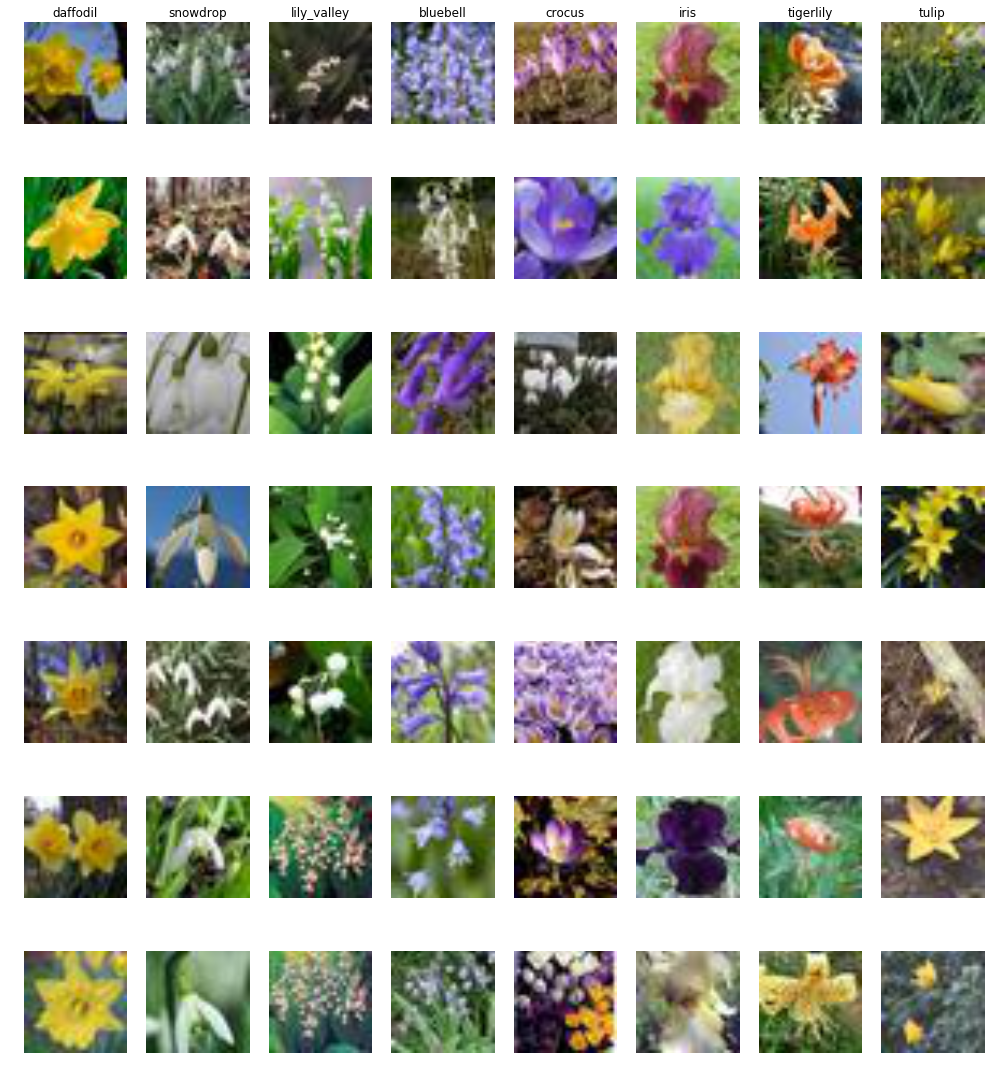

In [5]:
# Plot several images from each class
num_classes = 8
samples_per_class = 7
plt.figure(figsize=(1.7 * num_classes, 2.3 * samples_per_class))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
for y, class_name in enumerate(classes[:num_classes]):
    indexes = np.flatnonzero(y_all == y)
    indexes = np.random.choice(indexes, samples_per_class, replace=False)
    for i, index in enumerate(indexes):
        plt_index = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_index)
        plt.imshow(X_all[index].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

# Train a Nearest Neighbor Classifier with the Input Images (Un-normalized Input) - Working on it

## Split the Data into Train and Test Segments

In [6]:
# Split the data into train and test segments
import math

percentage_test_data = 0.2 # This means 20%

num_examples = len(X_all_rows)
num_test = int(math.floor(num_examples * percentage_test_data))
num_train = num_examples - num_test

X_train = X_all_rows[:num_train]
X_test = X_all_rows[num_train:]
y_train = y_all[:num_train]
y_test = y_all[num_train:]

## Run K-Nearest-Neighbors from scikit-learn

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# This does 1-nearest-neighbour with L1 distance
clf = KNeighborsClassifier(n_neighbors=1, p=1, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#accuracy = np.where(preds==y_test, 1, 0).sum() / float(len(y_test))
print 'accuracy: %f' % (np.mean(y_pred == y_test))

accuracy: 0.393382


## Plot a Confusion Matrix to Show Performance of KNN

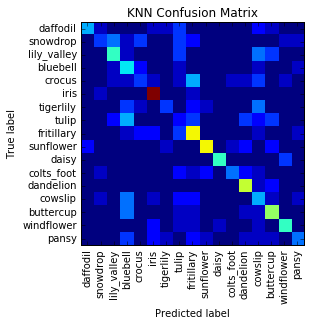

In [181]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
plt.imshow(confusion, interpolation='nearest')

tick_marks = np.arange(len(classes))
plt.title('KNN Confusion Matrix')
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## NearestNeighbor Class from Karpathy

In [158]:
import numpy as np

class NearestNeighbor:
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

        # loop over all test rows
        for i in xrange(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            #distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
            min_index = np.argmin(distances) # get the index with smallest distance
            Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

        return Ypred

## Use the NearestNeighbor Class from Karpathy

In [159]:
clf = NearestNeighbor()
clf.train(X_train, y_train)
predictions = clf.predict(X_test)
#accuracy = np.where(preds==y_test, 1, 0).sum() / float(len(y_test))
print 'accuracy: %f' % (np.mean(predictions == y_test))

accuracy: 0.419118


In [ ]:
accuracy_results = []
for n in range(1, 51, 2):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(train[features], train['high_quality'])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test['high_quality'], 1, 0).sum() / float(len(test))
    print "Neighbors: %d, Accuracy: %3f" % (n, accuracy)

    results.append([n, accuracy])

results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

# Trying Out Principal Component Analysis (PCA)

PCA is an unsupervised technique to reduce the dimensionality of the input data.
* Can use Randomized PCA or regular PCA

In [1]:
from sklearn.decomposition import PCA

n_components = 150

print "Extracting the top %d eigenflowers from %d flowers" % (n_components, X_train.shape[0])

pca = PCA(n_components=n_components, whiten=True) # Don't know about whiten

%time pca.fit(X_train)

print(pca.components_.shape)
eigenflowers = pca.components_

print(eigenflowers[0])

eigenflower_titles = ["eigenflower %d" % i for i in range(eigenflowers.shape[0])]
plot_gallery(eigenflowers, [0] * 150, 32, 32)

NameError: name 'X_train' is not defined

# Create `train.txt` and `test.txt` files for Caffe

In [52]:
from __future__ import division

import os
import random

base_dir = 'square_images2'
percentage_test_data = 0.20 # This means 20%

output_train_file = 'train.txt'
output_test_file = 'test.txt'


classes = ['daffodil',  'snowdrop', 'lily_valley', 'bluebell', 'crocus', 'iris', 
           'tigerlily', 'tulip', 'fritillary', 'sunflower', 'daisy', 'colts_foot', 
           'dandelion', 'cowslip', 'buttercup', 'windflower', 'pansy']

class_dict = { class_name: index for (index, class_name) in enumerate(classes)}


folders = os.listdir(base_dir)
folders = [folder for folder in folders if folder != '.DS_Store']

file_path_class_dict = dict()

for folder_name in folders:
    # We look up the class number based on the name of the folder the image is in.
    # This maps a folder name like 'daffodil' to a class number like 0.
    class_index = class_dict[folder_name]
    
    file_names = os.listdir(base_dir + '/' + folder_name)
    file_names = [name for name in file_names if name != '.DS_Store']
    
    for file_name in file_names:
        full_file_path = os.path.abspath(folder_name + '/' + file_name)
        file_path_class_dict[full_file_path] = class_index

print(len(file_path_class_dict))

file_path_class_items = file_path_class_dict.items()
random.shuffle(file_path_class_items)

num_files = len(file_path_class_items)
num_test = int(math.floor(num_files * percentage_test_data))
num_train = num_files - num_test

# Write the train.txt file
train_f = open(output_train_file, 'w')
for (file_path, class_index) in file_path_class_items[:num_train]:
    train_f.write("{0} {1}\n".format(file_path, class_index))
train_f.close()

# Write the test.txt file
test_f = open(output_test_file, 'w')
for (file_path, class_index) in file_path_class_items[num_train:]:
    test_f.write("{0} {1}\n".format(file_path, class_index))
test_f.close()

1360


# Some Random Test Stuff

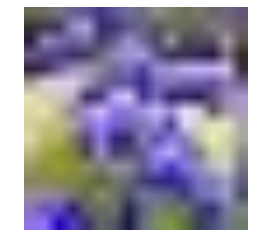

In [66]:
import matplotlib.pyplot as pl
import numpy as np

from PIL import Image

image_width = 16
image_height = 16

X = np.empty([80, image_width, image_height, 3])

I = Image.open('tiny_images_sub/bluebell/image_0241_tiny.jpg')
A = np.array(I)

pl.axis('off')
pl.imshow(A.astype('uint8'))